In [2]:
# Define the resampling rate in Hertz (Hz) for audio data
RATE_HZ = 16000

# Define the maximum audio interval length to consider in seconds
MAX_SECONDS = 10

# Calculate the maximum audio interval length in samples by multiplying the rate and seconds
MAX_LENGTH = RATE_HZ * MAX_SECONDS

# Define the minimum number of records per label required for the dataset
MIN_RECORDS_PER_LABEL = 26
TEST_SIZE = 0.1

In [2]:

import pandas as pd
file_path = '../data/train_audio/train_metadata.csv'  
df = pd.read_csv(file_path)
df.head()  

In [3]:
filtered_df = df[
    (df['secondary_labels'].apply(lambda x: isinstance(x, str) and len(x) == 2)) &
    (df['type'].apply(lambda x: 'call' in x)) &
    (df['rating'].apply(lambda x: x >= 3.0))  
]

print(filtered_df.shape)

df_filtered = filtered_df[['primary_label', 'type', 'latitude', 'longitude','rating', 'filename']].copy()
df_filtered['filename'] = '../data/train_audio/train_audio/' + df_filtered['filename'].astype(str)

df_filtered.head()

# Calculate label counts
label_counts = df_filtered['primary_label'].value_counts()

# Identify undersampled labels
undersampled_labels = label_counts[label_counts < MIN_RECORDS_PER_LABEL].index

# Remove rows with undersampled labels
df_filtered = df_filtered[~df_filtered['primary_label'].isin(undersampled_labels)]

# Print the shape of the resulting DataFrame
print(df_filtered.shape)

df_filtered.head()

(10333, 12)
(9336, 6)


,primary_label,type,latitude,longitude,rating,filename
0,asbfly,['call'],39.2297,118.1987,5.0,../data/train_audio/train_audio/asbfly/XC13489...
3,asbfly,['call'],21.1697,70.6005,4.0,../data/train_audio/train_audio/asbfly/XC20773...
4,asbfly,['call'],15.5442,73.7733,4.0,../data/train_audio/train_audio/asbfly/XC20921...
5,asbfly,['call'],15.5442,73.7733,4.0,../data/train_audio/train_audio/asbfly/XC20921...
7,asbfly,"['call', 'male', 'song']",44.3602,132.7989,4.0,../data/train_audio/train_audio/asbfly/XC26768...


In [4]:
# Retrieve unique values in the 'label' column of the DataFrame 'df'
unique_labels = df_filtered['primary_label'].unique()
unique_labels

print(len(unique_labels))

array(['asbfly', 'ashdro1', 'ashpri1', 'asikoe2', 'barswa', 'bcnher',
       'bkskit1', 'bkwsti', 'bladro1', 'blakit1', 'blhori1', 'blnmon1',
       'blrwar1', 'brnhao1', 'brnshr', 'brodro1', 'brwowl1', 'categr',
       'cohcuc1', 'comgre', 'comior1', 'comkin1', 'commoo3', 'commyn',
       'compea', 'comros', 'comsan', 'comtai1', 'copbar1', 'crseag1',
       'eaywag1', 'eucdov', 'eurcoo', 'gargan', 'gloibi', 'graher1',
       'grbeat1', 'grecou1', 'greegr', 'grefla1', 'grejun2', 'grewar3',
       'grnsan', 'grnwar1', 'grtdro1', 'gryfra', 'grywag', 'gybpri1',
       'gyhcaf1', 'hoopoe', 'houcro1', 'houspa', 'indpit1', 'insbab1',
       'insowl1', 'junowl1', 'kenplo1', 'labcro1', 'lblwar1', 'lirplo',
       'litegr', 'litgre1', 'litspi1', 'litswi1', 'marsan', 'nutman',
       'oripip1', 'piekin1', 'plapri1', 'purher1', 'pursun3', 'pursun4',
       'putbab1', 'rerswa1', 'revbul', 'rewbul', 'rewlap1', 'rocpig',
       'rorpar', 'ruftre2', 'shikra1', 'stbkin1', 'tibfly3', 'wemhar1',
       

In [5]:
bird_counts = df_filtered['primary_label'].value_counts()
print(bird_counts)

primary_label
comkin1    308
eurcoo     288
graher1    277
bkwsti     277
commoo3    270
          ... 
junowl1     30
asbfly      28
gryfra      28
grejun2     27
insowl1     26
Name: count, Length: 90, dtype: int64


In [6]:
from tqdm import tqdm
import torchaudio
import torch
import pandas as pd
import noisereduce as nr

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

def denoise_audio(audio):
    if audio.ndim == 2:  
        audio = audio[0]
    audio_denoised = nr.reduce_noise(y=audio, sr=RATE_HZ)
    return audio_denoised

def split_audio(file):
    try:
        audio, rate = torchaudio.load(str(file))
        audio = audio.to(DEVICE)

        if rate != RATE_HZ:
            transform = torchaudio.transforms.Resample(orig_freq=rate, new_freq=RATE_HZ).to(DEVICE)
            audio = transform(audio)

        num_segments = audio.size(1) // MAX_LENGTH
        segmented_audio = []
        
        for i in range(num_segments):
            start = i * MAX_LENGTH
            end = start + MAX_LENGTH
            segment = audio[:, start:end]

            segment_np = segment.squeeze().cpu().numpy()
            segment_denoised = denoise_audio(segment_np)

            segment_tensor = torch.tensor(segment_denoised, device=DEVICE)

            segmented_audio.append(segment_tensor.cpu().numpy())  

        df_segments = pd.DataFrame({'audio': segmented_audio})

        del transform
        gc.collect()
        torch.cuda.empty_cache()


        return df_segments
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        return None

df_list = []
for file, label in tqdm(zip(df_filtered['filename'].values, df_filtered['primary_label'].values), total=len(df_filtered)):
    result_df = split_audio(file)
    if result_df is not None:
        result_df['label'] = label
        df_list.append(result_df)

final_df = pd.concat(df_list, axis=0).reset_index(drop=True)

print(f"Total segments processed: {len(final_df)}")
final_df.head()

Using device: cuda


100%|██████████| 9336/9336 [27:09<00:00,  5.73it/s]   


Total segments processed: 27583


,audio,label
0,"[5.780226e-10, 4.294094e-10, 1.6691398e-10, -2...",asbfly
1,"[0.0002547179, -0.0003185024, 0.0005010311, 0....",asbfly
2,"[-2.5786356e-08, 3.0428956e-07, -5.7121092e-08...",asbfly
3,"[3.4658624e-05, 3.1965305e-05, 3.0010215e-05, ...",asbfly
4,"[0.0023148223, -0.00041703868, -0.004004752, 3...",asbfly


In [20]:
final_df.to_pickle('../data/split_seg_denoise_full.csv')

In [24]:
print(len(final_df))

27583


In [7]:
import pandas as pd
from sklearn.utils import resample

print(final_df['label'].value_counts())  

min_samples = final_df['label'].value_counts().min()
balanced_df = pd.concat(
    [
        resample(group, replace=False, n_samples=min_samples, random_state=42)
        for _, group in final_df.groupby('label')
    ]
)

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(balanced_df['label'].value_counts()) 

label
commyn     1177
houspa     1030
graher1     991
bkwsti      962
rorpar      928
           ... 
piekin1      65
oripip1      57
marsan       50
gryfra       38
compea       26
Name: count, Length: 90, dtype: int64
label
bladro1    26
bkskit1    26
kenplo1    26
brodro1    26
eaywag1    26
           ..
gryfra     26
plapri1    26
comior1    26
bcnher     26
hoopoe     26
Name: count, Length: 90, dtype: int64


In [25]:
import gc


gc.collect()

17

In [23]:
print(len(balanced_df))

2340


In [21]:
balanced_df.to_pickle('../data/split_seg_denoise_balanced.csv')

In [1]:
import pandas as pd

df = pd.read_pickle('../data/split_seg_denoise_full.csv')

print(len(df))

27583


In [3]:
df.head()

,audio,label
0,"[5.780226e-10, 4.294094e-10, 1.6691398e-10, -2...",asbfly
1,"[0.0002547179, -0.0003185024, 0.0005010311, 0....",asbfly
2,"[-2.5786356e-08, 3.0428956e-07, -5.7121092e-08...",asbfly
3,"[3.4658624e-05, 3.1965305e-05, 3.0010215e-05, ...",asbfly
4,"[0.0023148223, -0.00041703868, -0.004004752, 3...",asbfly


In [4]:
print(df['label'].value_counts())

label
commyn     1177
houspa     1030
graher1     991
bkwsti      962
rorpar      928
           ... 
piekin1      65
oripip1      57
marsan       50
gryfra       38
compea       26
Name: count, Length: 90, dtype: int64


In [4]:
from IPython.display import Audio

def play_audio(audio, sample_rate):
    return Audio(audio, rate=sample_rate)

# Play the original and denoised audio
play_audio(df.iloc[2]['audio'], RATE_HZ)  # Denoised audio

In [5]:
print(df.memory_usage(deep=True).sum() / 1e6, "MB")  

5.062255 MB


In [6]:
df.head()

,audio,label
0,"[5.780226e-10, 4.294094e-10, 1.6691398e-10, -2...",asbfly
1,"[0.0002547179, -0.0003185024, 0.0005010311, 0....",asbfly
2,"[-2.5786356e-08, 3.0428956e-07, -5.7121092e-08...",asbfly
3,"[3.4658624e-05, 3.1965305e-05, 3.0010215e-05, ...",asbfly
4,"[0.0023148223, -0.00041703868, -0.004004752, 3...",asbfly


In [9]:
import torch
import numpy as np

# Ensure audio data is processed on the GPU
def process_audio_on_gpu(audio):
    if isinstance(audio, (list, np.ndarray)):
        audio_tensor = torch.tensor(audio, dtype = torch.float32).cuda()
        return audio_tensor.cpu().numpy()
    return audio

df['audio'] = df['audio'].apply(process_audio_on_gpu)

df['label'] = df['label'].astype(str)

print("Processing complete!")

: 

: 

In [5]:
df = df[~df['audio'].isnull()]

In [6]:
if 'filename' in df.columns:
    df = df.drop(['filename'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27583 entries, 0 to 27582
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   audio   27583 non-null  object
 1   label   27583 non-null  object
dtypes: object(2)
memory usage: 431.1+ KB


In [7]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(df[['label']])

print(classes)

weights = compute_class_weight(class_weight='balanced', classes=classes, y=df['label'])

# Create a dictionary mapping each class to its respective class weight.
class_weights = dict(zip(classes, weights))

# Print the computed class weights to the console.
print(class_weights)

['asbfly' 'ashdro1' 'ashpri1' 'asikoe2' 'barswa' 'bcnher' 'bkskit1'
 'bkwsti' 'bladro1' 'blakit1' 'blhori1' 'blnmon1' 'blrwar1' 'brnhao1'
 'brnshr' 'brodro1' 'brwowl1' 'categr' 'cohcuc1' 'comgre' 'comior1'
 'comkin1' 'commoo3' 'commyn' 'compea' 'comros' 'comsan' 'comtai1'
 'copbar1' 'crseag1' 'eaywag1' 'eucdov' 'eurcoo' 'gargan' 'gloibi'
 'graher1' 'grbeat1' 'grecou1' 'greegr' 'grefla1' 'grejun2' 'grewar3'
 'grnsan' 'grnwar1' 'grtdro1' 'gryfra' 'grywag' 'gybpri1' 'gyhcaf1'
 'hoopoe' 'houcro1' 'houspa' 'indpit1' 'insbab1' 'insowl1' 'junowl1'
 'kenplo1' 'labcro1' 'lblwar1' 'lirplo' 'litegr' 'litgre1' 'litspi1'
 'litswi1' 'marsan' 'nutman' 'oripip1' 'piekin1' 'plapri1' 'purher1'
 'pursun3' 'pursun4' 'putbab1' 'rerswa1' 'revbul' 'rewbul' 'rewlap1'
 'rocpig' 'rorpar' 'ruftre2' 'shikra1' 'stbkin1' 'tibfly3' 'wemhar1'
 'whbwat1' 'whbwoo2' 'whiter2' 'whtkin2' 'woosan' 'zitcis1']
{'asbfly': 2.8642782969885774, 'ashdro1': 2.1891269841269843, 'ashpri1': 3.879465541490858, 'asikoe2': 1.00484517304

In [8]:
# Create a list of unique labels
labels_list = sorted(list(df['label'].unique()))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'asbfly', 1: 'ashdro1', 2: 'ashpri1', 3: 'asikoe2', 4: 'barswa', 5: 'bcnher', 6: 'bkskit1', 7: 'bkwsti', 8: 'bladro1', 9: 'blakit1', 10: 'blhori1', 11: 'blnmon1', 12: 'blrwar1', 13: 'brnhao1', 14: 'brnshr', 15: 'brodro1', 16: 'brwowl1', 17: 'categr', 18: 'cohcuc1', 19: 'comgre', 20: 'comior1', 21: 'comkin1', 22: 'commoo3', 23: 'commyn', 24: 'compea', 25: 'comros', 26: 'comsan', 27: 'comtai1', 28: 'copbar1', 29: 'crseag1', 30: 'eaywag1', 31: 'eucdov', 32: 'eurcoo', 33: 'gargan', 34: 'gloibi', 35: 'graher1', 36: 'grbeat1', 37: 'grecou1', 38: 'greegr', 39: 'grefla1', 40: 'grejun2', 41: 'grewar3', 42: 'grnsan', 43: 'grnwar1', 44: 'grtdro1', 45: 'gryfra', 46: 'grywag', 47: 'gybpri1', 48: 'gyhcaf1', 49: 'hoopoe', 50: 'houcro1', 51: 'houspa', 52: 'indpit1', 53: 'insbab1', 54: 'insowl1', 55: 'junowl1', 56: 'kenplo1', 57: 'labcro1', 58: 'lblwar1', 59: 'lirplo', 60: 'litegr', 61: 'litgre1', 62: 'litspi1', 63: 'litswi1', 64: 'marsan', 65: 'nutman', 66: 'oripip1', 67:

In [9]:
print(df['audio'].iloc[0].dtype)

print(df['label'].iloc[0])

float32
asbfly


In [10]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [11]:
from transformers import Wav2Vec2Processor,AutoFeatureExtractor
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score

processor = Wav2Vec2Processor.from_pretrained("../model/30_epoch")
# facebook/wav2vec2-base-960h")

class AudioDataset(Dataset):
    def __init__(self, dataframe, label2id, processor, device='cuda'):
        """
        Args:
            dataframe (pd.DataFrame): The dataframe containing audio and labels
            label2id (dict): A dictionary mapping label names to integer IDs
            processor (Wav2Vec2Processor): The processor for audio feature extraction
            device (str): The device where the data should be loaded ('cuda' or 'cpu')
        """
        self.dataframe = dataframe
        self.label2id = label2id
        self.processor = processor
        self.device = device

    def __len__(self):
        """Return the total number of samples"""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Fetch and preprocess a single sample"""
        audio = np.array(self.dataframe.iloc[idx]['audio'], dtype=np.float32)
                
        label = self.label2id[self.dataframe.iloc[idx]['label']]
        
        # Apply feature extraction to the audio using the processor
        inputs = self.processor(audio, sampling_rate=RATE_HZ, max_length=80000, truncation=True, return_tensors="pt")
        
        # Convert audio and label to tensors and move to GPU
        audio_tensor = inputs.input_values.squeeze(0).to(self.device)  # Use the extracted features (input_values)
        label_tensor = torch.tensor(label).to(self.device)

        return {
            'input_values': audio_tensor, 
            'label': label_tensor
        }

device='cuda' if torch.cuda.is_available() else 'cpu'
# Now, create datasets for train and test using the split DataFrames
train_dataset = AudioDataset(train_df, label2id, processor, device=device)
test_dataset = AudioDataset(test_df, label2id, processor, device=device)

# Check the size of the splits
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 22066
Test dataset size: 5517


In [12]:
import numpy as np
import evaluate

# Load the accuracy metric
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    # Extract the model's predictions and true labels from eval_pred
    predictions, label_ids = eval_pred
    predictions = np.exp(predictions) / np.exp(predictions).sum(axis=1, keepdims=True)
    
    # Compute the predicted class (the index of the highest probability)
    predicted_classes = predictions.argmax(axis=1)

    acc_score = accuracy.compute(predictions=predicted_classes, references=label_ids)["accuracy"]

    return {
        "accuracy": acc_score
    }

In [15]:
from transformers import AutoModelForAudioClassification

# Load the model with the correct number of labels
model = AutoModelForAudioClassification.from_pretrained("../model/30_epoch",
    # "facebook/wav2vec2-base-960h", 
    num_labels=len(labels_list)  # Replace with your number of classes
)

# Set the model's id2label and label2id mappings
model.config.id2label = id2label 

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to GPU (or CPU if CUDA is not available)
model = model.to(device)

# Print the number of trainable parameters (in millions)
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_trainable_params / 1e6}M")

print(model)

Number of trainable parameters: 94.591706M
Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (4): Wav2Vec2NoLayerNormConvLayer(
          (conv

In [17]:
import torch
from transformers import AutoProcessor, AutoModelForAudioClassification, Trainer, TrainingArguments
import evaluate
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 4
warmup_steps = 50
weight_decay = 0.02
num_train_epochs = 10
model_name = "bird_sounds_classification"
model.to(device)

# Create TrainingArguments object to configure the training process
training_args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=3e-6,
    logging_strategy='steps',
    logging_first_step=True,
    load_best_model_at_end=True,
    logging_steps=1000,
    evaluation_strategy='epoch',
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    eval_steps=1000,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    save_strategy='epoch',
    save_total_limit=1,
    report_to="none",
    fp16=True, 
)

# Create a Trainer object to manage the training process
# trainer = Trainer(
#     model=model,  
#     args=training_args,  
#     train_dataset=train_dataset,  
#     eval_dataset=test_dataset,
#     tokenizer=processor,  
#     compute_metrics=compute_metrics
# )

# print(training_args.device)  
# print(model.device) 

# trainer.train()

In [18]:
from transformers import Trainer
import torch

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        class_weights_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float32).to(logits.device)
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,  
    args=training_args,  
    train_dataset=train_dataset,  
    eval_dataset=test_dataset,
    tokenizer=processor,  
    compute_metrics=compute_metrics
)

trainer.train()

/home/hice1/smurarka7/.conda/envs/birdc/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=55170, training_loss=1.546439080914013, metrics={'train_runtime': 4691.6961, 'train_samples_per_second': 47.032, 'train_steps_per_second': 11.759, 'total_flos': 1.0018850806060798e+19, 'train_loss': 1.546439080914013, 'epoch': 10.0})

In [19]:
trainer.evaluate()

/scratch/988517/ipykernel_1556109/2903218235.py:10: RuntimeWarning: overflow encountered in exp
  predictions = np.exp(predictions) / np.exp(predictions).sum(axis=1, keepdims=True)
/home/hice1/smurarka7/.local/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/scratch/988517/ipykernel_1556109/2903218235.py:10: RuntimeWarning: invalid value encountered in divide
  predictions = np.exp(predictions) / np.exp(predictions).sum(axis=1, keepdims=True)


{'eval_loss': 2.4378440380096436,
 'eval_accuracy': 0.6189958310676092,
 'eval_runtime': 22.1798,
 'eval_samples_per_second': 248.74,
 'eval_steps_per_second': 62.219,
 'epoch': 10.0}

In [20]:
# Use the trained 'trainer' to make predictions on the test dataset.
outputs = trainer.predict(test_dataset)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

/scratch/988517/ipykernel_1556109/2903218235.py:10: RuntimeWarning: overflow encountered in exp
  predictions = np.exp(predictions) / np.exp(predictions).sum(axis=1, keepdims=True)
/home/hice1/smurarka7/.local/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/scratch/988517/ipykernel_1556109/2903218235.py:10: RuntimeWarning: invalid value encountered in divide
  predictions = np.exp(predictions) / np.exp(predictions).sum(axis=1, keepdims=True)


{'test_loss': 2.4378440380096436, 'test_accuracy': 0.6189958310676092, 'test_runtime': 24.7481, 'test_samples_per_second': 222.926, 'test_steps_per_second': 55.762}


Accuracy: 0.6262
F1 Score: 0.4869


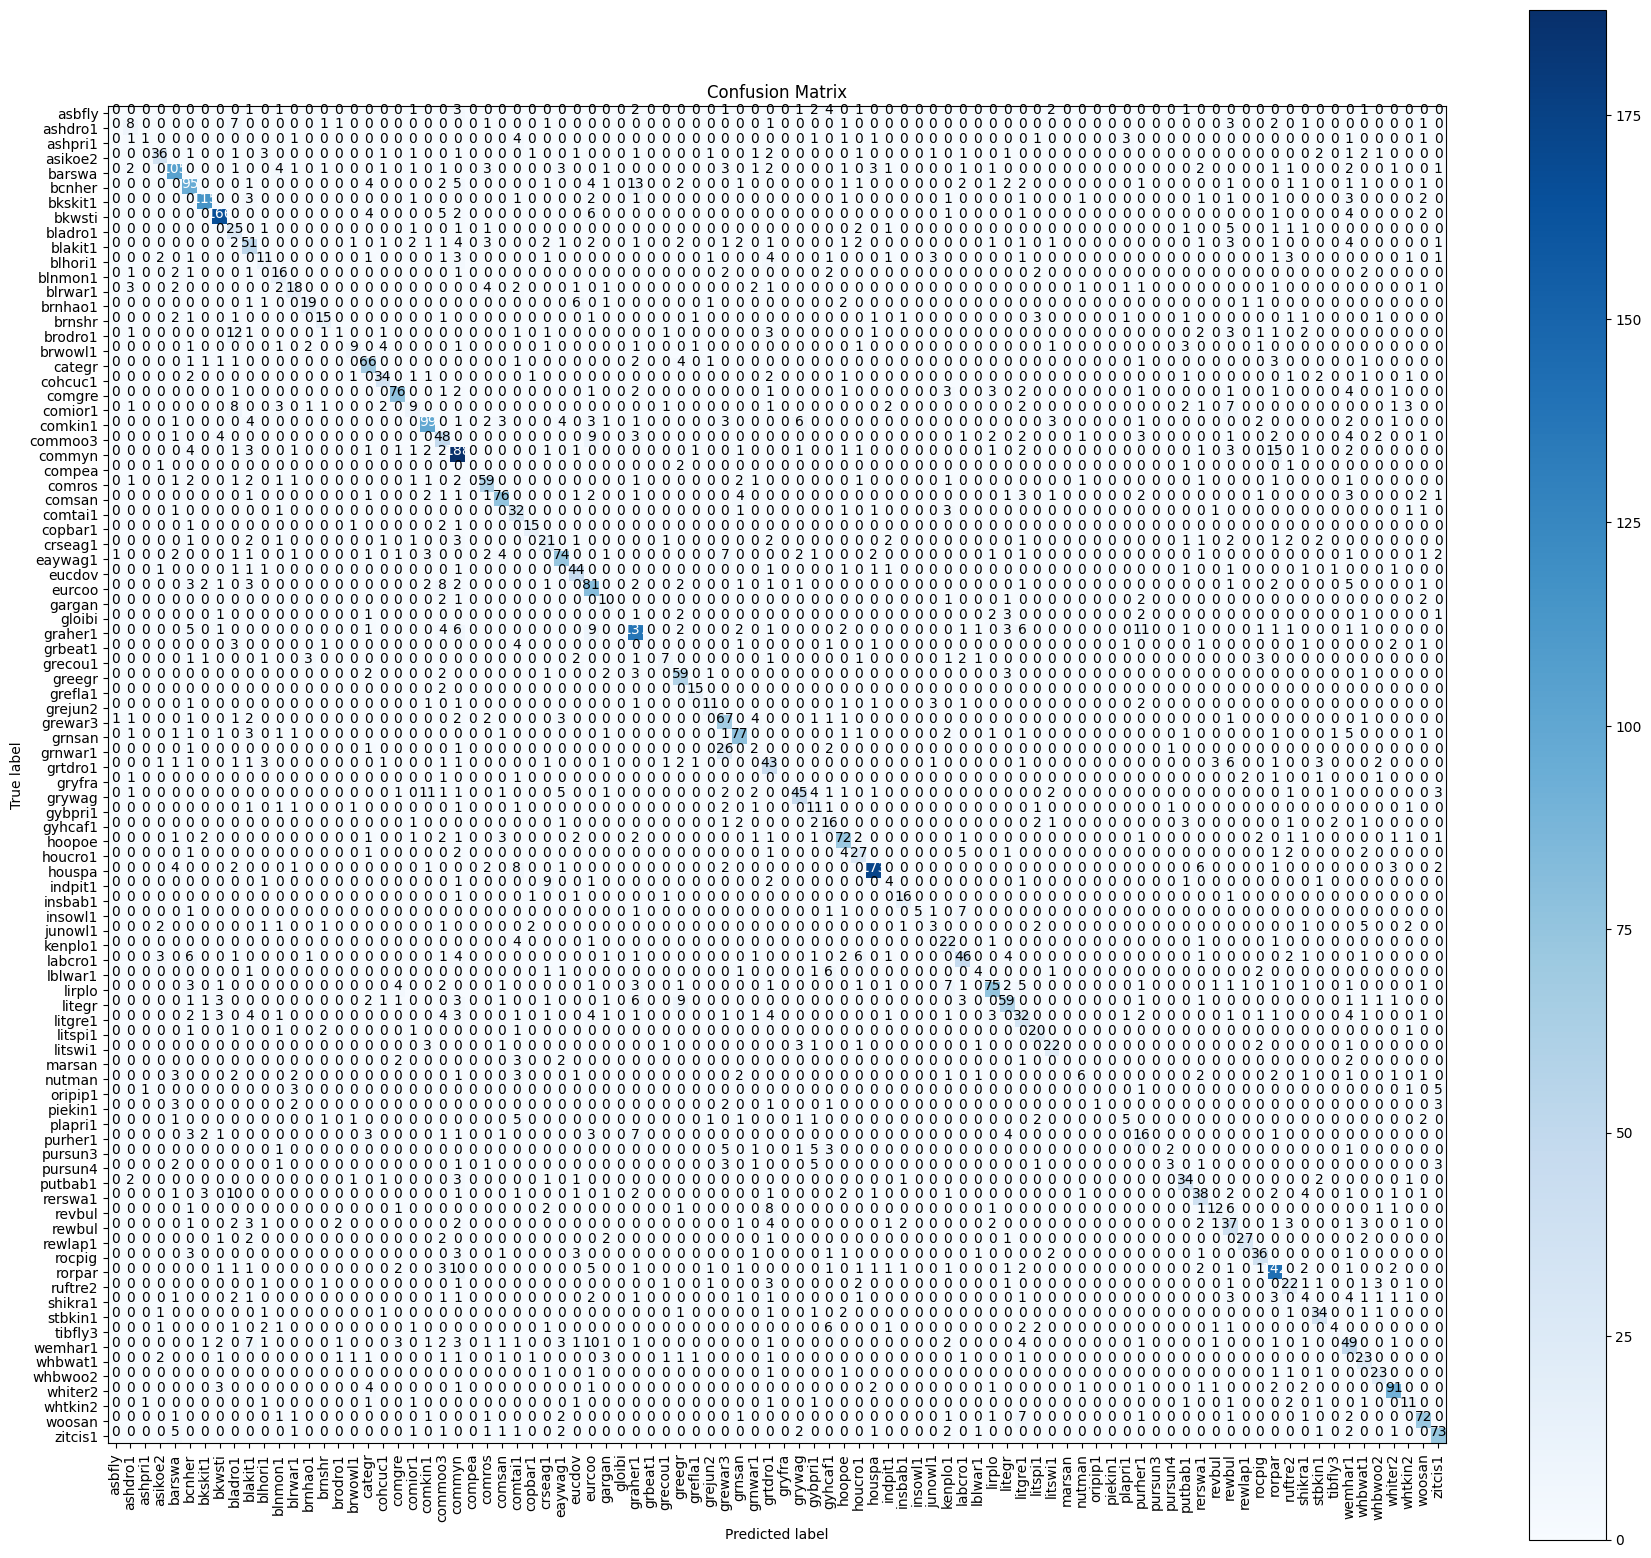


Classification report:

              precision    recall  f1-score   support

      asbfly     0.0000    0.0000    0.0000        21
     ashdro1     0.3333    0.2857    0.3077        28
     ashpri1     0.3333    0.0625    0.1053        16
     asikoe2     0.7200    0.5902    0.6486        61
      barswa     0.7447    0.7241    0.7343       145
      bcnher     0.6419    0.6552    0.6485       145
     bkskit1     0.8915    0.8519    0.8712       135
      bkwsti     0.8691    0.8646    0.8668       192
     bladro1     0.2778    0.6098    0.3817        41
     blakit1     0.5000    0.5426    0.5204        94
     blhori1     0.3667    0.2973    0.3284        37
     blnmon1     0.4103    0.5333    0.4638        30
     blrwar1     0.5143    0.4390    0.4737        41
     brnhao1     0.7308    0.5758    0.6441        33
      brnshr     0.6000    0.4688    0.5263        32
     brodro1     0.1667    0.0303    0.0513        33
     brwowl1     0.5625    0.3333    0.4186        27
  

/home/hice1/smurarka7/.conda/envs/birdc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hice1/smurarka7/.conda/envs/birdc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hice1/smurarka7/.conda/envs/birdc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

In [21]:
import matplotlib.pyplot as plt  
from sklearn.metrics import (
    accuracy_score,  
    f1_score,  
    confusion_matrix,  
    classification_report  
)
import numpy as np
import itertools

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'
    
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a relatively small number of labels
if len(labels_list) <= 120:
    cm = confusion_matrix(y_true, y_pred)  
    plot_confusion_matrix(cm, labels_list, figsize=(18, 16), is_norm=False)

print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [23]:
# Saving the trained model to a file for future use.
trainer.save_model("../model/modified_error_epoch")